# **TS and Anytime Algorithms for Stochastic MABs**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import beta as beta_dist 
# scipy is to plot the probability density function
# not strictly neceassary

### We consider Stochastic MABs with Bernoulli distributions

In [48]:
class Environment:
    def __init__(self):
        pass

    def round(self, a_t):
        pass

In [49]:
class BernoulliEnvironment(Environment):
    def __init__(self, p, T):
        self.K = len(p)
        self.rewards = np.random.binomial(n=1, p=p, size=(T, self.K))
        self.t = 0

    def round(self, a_t):
        r_t = self.rewards[self.t, a_t]
        self.t +=1
        return r_t

In [50]:
seed = 17

### We start with ETC and UCB1 agents

In [51]:
# this is the blueprint of an Agent-type class, we can customize this with our strategy
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

In [52]:
class ETCAgent(Agent):
    def __init__(self, K, T, T0=None):
        self.K = K 
        self.T = T
        self.T0 = (T/K)**(2/3)*np.log(T)**(1/3) if T0 is None else T0
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t <= self.K*self.T0:
            self.a_t = self.t % self.K
        else:
            self.a_t = np.argmax(self.average_rewards)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

In [53]:
class UCB1Agent(Agent):
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### Let us define some function to evaluate the performance of any given agnet on any given instance

In [54]:
def evaluate_agent(p, T, agent_init, n_trials, seed=42):
    best_action = np.argmax(p)
    K = len(p)
    expected_clairvoyant_rewards = np.repeat(p[best_action], T)

    regret_per_trial = []

    np.random.seed(seed)
    for _ in range(n_trials):
        env = BernoulliEnvironment(p, T)
        agent = agent_init(K, T)

        agent_rewards = np.array([])

        for t in range(T):
            a_t = agent.pull_arm()
            r_t = env.round(a_t)
            agent.update(r_t)

            agent_rewards = np.append(agent_rewards, r_t)

        cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
        regret_per_trial.append(cumulative_regret)

    regret_per_trial = np.array(regret_per_trial)

    avg_regret = regret_per_trial.mean(axis=0)
    regret_sd = regret_per_trial.std(axis=0)
    return avg_regret, regret_sd

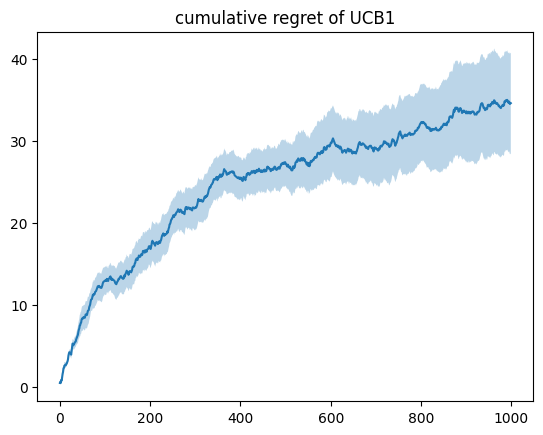

In [55]:
p = np.array([0.25, 0.5, 0.75])
T = 1000
n_trials = 10

average_regret, regret_sd = evaluate_agent(p,T,lambda K,T: UCB1Agent(K,T), n_trials)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()

### Similarly, we want to comapre the performances of two different agents 

In [56]:
def compare_agents(p, T, agent1_init, agent2_init, n_trials, seed=42):
    best_action = np.argmax(p)
    K = len(p)
    expected_clairvoyant_rewards = np.repeat(p[best_action], T)

    first_regret_per_trial = []
    sec_regret_per_trial = []

    np.random.seed(seed)
    for _ in range(n_trials):
        state = np.random.get_state()
        env = BernoulliEnvironment(p, T)
        agent1 = agent1_init(K, T)

        agent_rewards = np.array([])
        for t in range(T):
            a_t = agent1.pull_arm()
            r_t = env.round(a_t)
            agent1.update(r_t)

            agent_rewards = np.append(agent_rewards, r_t)
        
        cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
        first_regret_per_trial.append(cumulative_regret)

        np.random.set_state(state)
        env = BernoulliEnvironment(p, T)
        agent2 = agent2_init(K, T)

        agent_rewards = np.array([])
        for t in range(T):
            a_t = agent2.pull_arm()
            r_t = env.round(a_t)
            agent2.update(r_t)

            agent_rewards = np.append(agent_rewards, r_t)

        cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
        sec_regret_per_trial.append(cumulative_regret)

    first_regret_per_trial = np.array(first_regret_per_trial)
    sec_regret_per_trial = np.array(sec_regret_per_trial)

    first_avg_regret = first_regret_per_trial.mean(axis=0)
    first_regret_sd = first_regret_per_trial.std(axis=0)
    sec_avg_regret = sec_regret_per_trial.mean(axis=0)
    sec_regret_sd = sec_regret_per_trial.std(axis=0)
    return (first_avg_regret, first_regret_sd), (sec_avg_regret, sec_regret_sd)

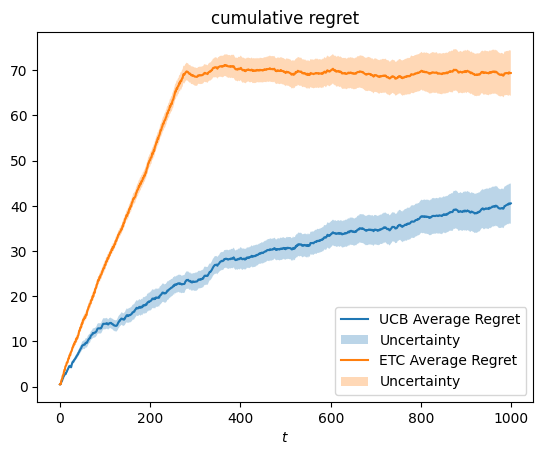

In [57]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000

n_trials = 20

ucb_results, etc_results = compare_agents(p,T,
                                          lambda K,T : UCB1Agent(K, T), 
                                          lambda K,T : ETCAgent(K, T, (T/K)**(2/3)*np.log(T)**(1/3)),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
etc_average_regret, etc_regret_sd = etc_results


plt.plot(np.arange(T), ucb_average_regret, label='UCB Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), etc_average_regret, label='ETC Average Regret')
plt.fill_between(np.arange(T),
                etc_average_regret-etc_regret_sd/np.sqrt(n_trials),
                etc_average_regret+etc_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()


### What if we do not kown the time horizon $T$?

### Algorithms that do not need the time horizon as input are called **anytime algorithms**.

### **Doubling trick**: a simple way to build an anytime algorithm $\mathcal{A}$ given another that depends on $T$
### Let $T_i = 2^{i-1}$. Run $\mathcal{A}$ for T_0 rounds. Then re-initialize $\mathcal{A}$ and run it for $T_1$ rounds, and so on... 

### The doubling trick is a general method that works even in adversarial and contextual settings

In [58]:
class DoublingTrickAgent(Agent):
    def __init__(self, K, agent_init):
        self.K = K
        self.agent_init = agent_init
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
        self.i = 1
        self.next_pahse_start = self.t + 2**(self.i-1)
        self.current_agent = self.agent_init(K,2**self.i)
    
    def pull_arm(self):
        self.a_t = self.current_agent.pull_arm()
        return self.a_t
    
    def update(self, r_t):
        self.current_agent.update(r_t)
        self.N_pulls[self.a_t] += 1
        self.t += 1
        if self.t == self.next_pahse_start:
            self.i += 1
            self.next_pahse_start = self.t + 2**self.i
            self.current_agent = self.agent_init(self.K,2**self.i)

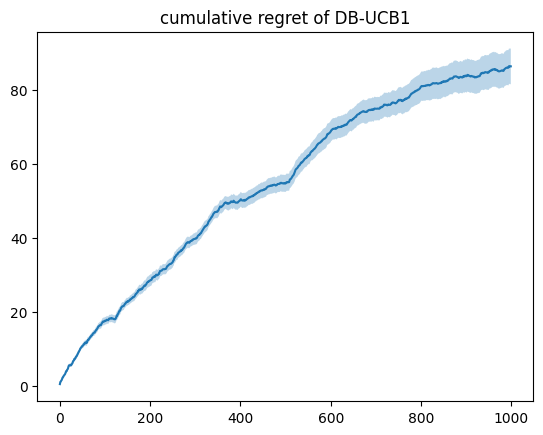

In [59]:
p = np.array([0.25, 0.5, 0.75])
T = 1000
n_trials = 20

ucb_init = lambda K,Ti: UCB1Agent(K,Ti)

average_regret, regret_sd = evaluate_agent(p,T,lambda K,T: DoublingTrickAgent(K, ucb_init), n_trials)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of DB-UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()

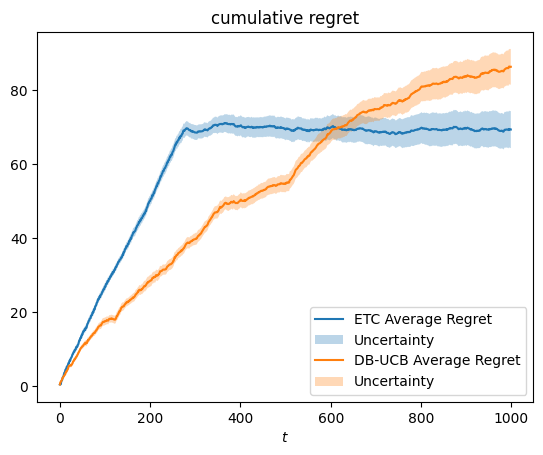

In [60]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000

n_trials = 20

ucb_init = lambda K,Ti: UCB1Agent(K,Ti)

ucb_results, etc_results = compare_agents(p,T,
                                          lambda K,T : ETCAgent(K, T), 
                                          lambda K,T : DoublingTrickAgent(K, ucb_init),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
etc_average_regret, etc_regret_sd = etc_results


plt.plot(np.arange(T), ucb_average_regret, label='ETC Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), etc_average_regret, label='DB-UCB Average Regret')
plt.fill_between(np.arange(T),
                etc_average_regret-etc_regret_sd/np.sqrt(n_trials),
                etc_average_regret+etc_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()

### The doubling trick gets better as the time horizon increases. Asymptotically, it performs ebtter than ETC

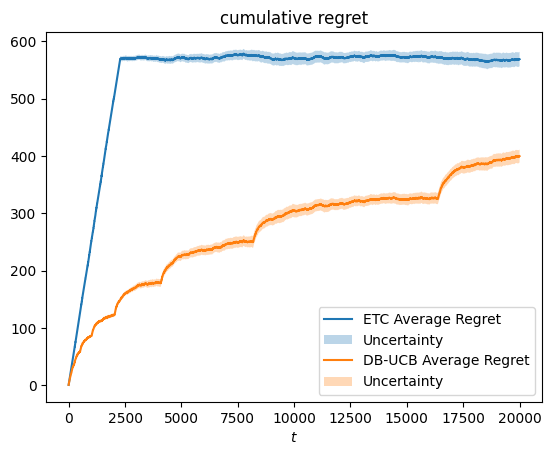

In [61]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 20000

n_trials = 20

ucb_init = lambda K,Ti: UCB1Agent(K,Ti)

ucb_results, etc_results = compare_agents(p,T,
                                          lambda K,T : ETCAgent(K, T), 
                                          lambda K,T : DoublingTrickAgent(K, ucb_init),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
etc_average_regret, etc_regret_sd = etc_results


plt.plot(np.arange(T), ucb_average_regret, label='ETC Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), etc_average_regret, label='DB-UCB Average Regret')
plt.fill_between(np.arange(T),
                etc_average_regret-etc_regret_sd/np.sqrt(n_trials),
                etc_average_regret+etc_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()

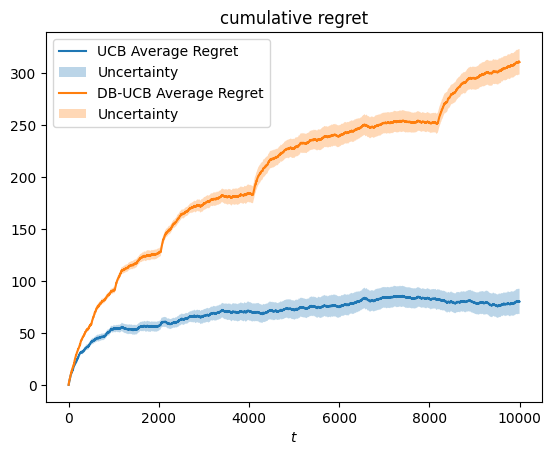

In [62]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 10000

n_trials = 20

ucb_init = lambda K,Ti: UCB1Agent(K,Ti)

ucb_results, etc_results = compare_agents(p,T,
                                          lambda K,T : UCB1Agent(K, T), 
                                          lambda K,T : DoublingTrickAgent(K, ucb_init),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
etc_average_regret, etc_regret_sd = etc_results


plt.plot(np.arange(T), ucb_average_regret, label='UCB Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), etc_average_regret, label='DB-UCB Average Regret')
plt.fill_between(np.arange(T),
                etc_average_regret-etc_regret_sd/np.sqrt(n_trials),
                etc_average_regret+etc_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()

### UCB can also be made anytime by changing the upper confidence bounds:
### $UCB_t(a) = \hat{\mu}(a) +\sqrt{\frac{2\log(\mathbf{t})}{N_{t-1}(a)}} \quad \forall a$

In [63]:
class AnytimeUCB1Agent(Agent):
    def __init__(self, K, range=1):
        self.K = K
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log((self.t+1))/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

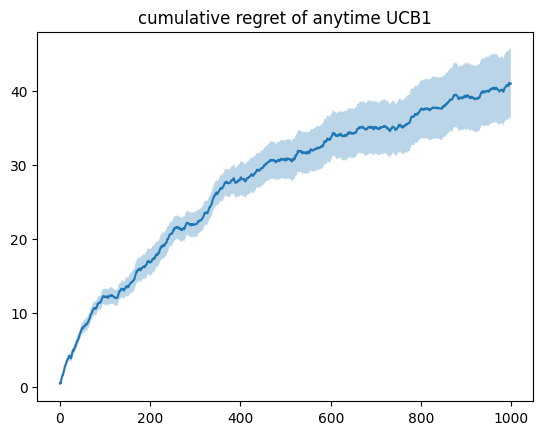

In [64]:
p = np.array([0.25, 0.5, 0.75])
T = 1000
n_trials = 20

average_regret, regret_sd = evaluate_agent(p,T,lambda K,T: AnytimeUCB1Agent(K), n_trials)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of anytime UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()

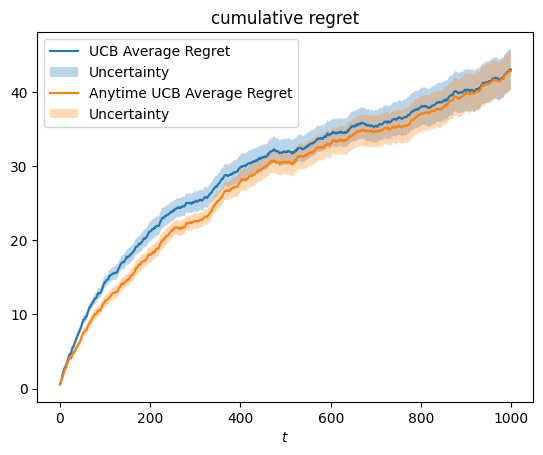

In [65]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000

n_trials = 40

ucb_results, etc_results = compare_agents(p,T,
                                          lambda K,T : UCB1Agent(K, T), 
                                          lambda K,T : AnytimeUCB1Agent(K),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
anytime_average_regret, anytime_regret_sd_regret_sd = etc_results


plt.plot(np.arange(T), ucb_average_regret, label='UCB Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), anytime_average_regret, label='Anytime UCB Average Regret')
plt.fill_between(np.arange(T),
                anytime_average_regret-anytime_regret_sd_regret_sd/np.sqrt(n_trials),
                anytime_average_regret+anytime_regret_sd_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()

### Visual representation of confidence intervals shrinking **and expanding**

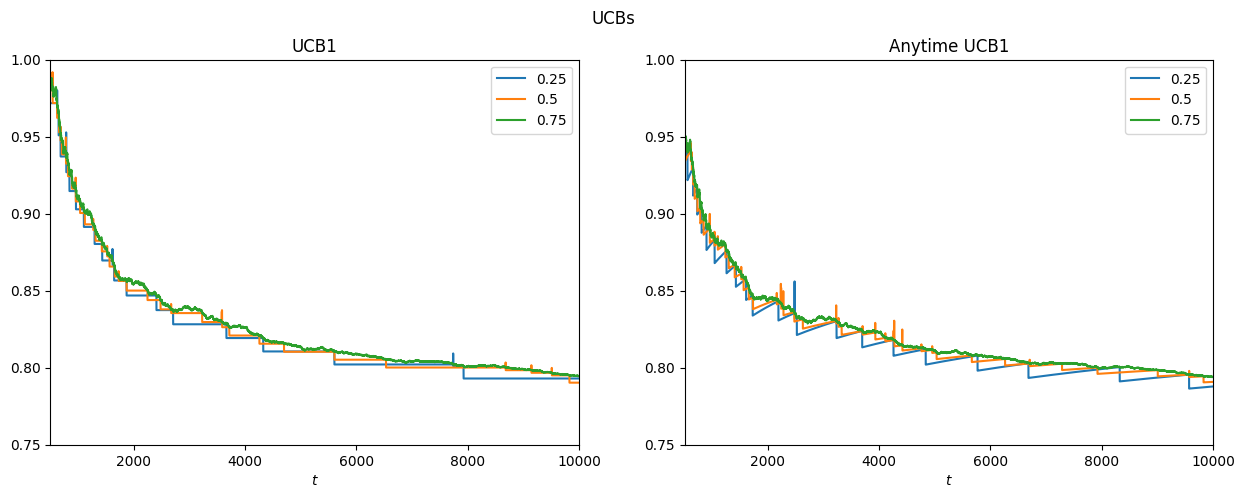

array([  56.,  158., 9786.])

In [66]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
# sigma = 0.1
T = 10000

np.random.seed(seed)
env = BernoulliEnvironment(p, T)
np.random.seed(seed)
anytime_env = BernoulliEnvironment(p, T)

ucb_agent = UCB1Agent(K, T)
anytime_ucb_agent = AnytimeUCB1Agent(K)

ci_widths = np.zeros((T,K))
curr_average = np.zeros((T,K))

anytime_ci_widths = np.zeros((T,K))
anytime_curr_average = np.zeros((T,K))

for t in range(T):
    a_t = ucb_agent.pull_arm()
    r_t = env.round(a_t)
    ucb_agent.update(r_t)

    ci_widths[t,:] = np.sqrt(2*np.log(T)/np.maximum(ucb_agent.N_pulls,0.01))
    curr_average[t,:] = curr_average[t-1,:]
    curr_average[t,a_t] += (r_t - curr_average[t,a_t])/ucb_agent.N_pulls[a_t]

    a_t = anytime_ucb_agent.pull_arm()
    r_t = anytime_env.round(a_t)
    anytime_ucb_agent.update(r_t)

    anytime_ci_widths[t,:] = np.sqrt(2*np.log(t+1)/np.maximum(anytime_ucb_agent.N_pulls,0.01))
    anytime_curr_average[t,:] = anytime_curr_average[t-1,:]
    anytime_curr_average[t,a_t] += (r_t - anytime_curr_average[t,a_t])/anytime_ucb_agent.N_pulls[a_t]

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
fig.suptitle('UCBs')

ax1.plot(curr_average+ci_widths,label=p)
ax1.set_title('UCB1')
ax1.set_xlabel('$t$')
ax1.set_ylim(0.75,1)
ax1.set_xlim(T/20, T)
ax1.legend()

ax2.plot(anytime_curr_average+anytime_ci_widths,label=p)
ax2.set_title('Anytime UCB1')
ax2.set_xlabel('$t$')
ax2.set_ylim(0.75,1)
ax2.set_xlim(T/20, T)
# obs: the sqrt(log(t)) increment seems a straight line for large t
# ax2.set_ylim(0.78,0.83)
# ax2.set_xlim(6000, 7000)
# while for small t
# ax2.set_ylim(1,2)
# ax2.set_xlim(10, 100)
ax2.legend()

plt.show()
anytime_ucb_agent.N_pulls

## **The Thompson Sampling Algorithm**

### UCB1 is a deterministic algorithm, i.e., given the same sequence of rewards the chosen actions will always be the same. It has been observed that often, in practice, randomized algorithm can perform better.

### We thus introduce Thompson Sampling, an algorithm having similar theoretical guarantees of UCB1, but taking randomized decisions.

In [67]:
class TSAgent(Agent):
    def __init__(self, K):
        self.K = K
        self.a_t = None
        self.alpha, self.beta = np.ones(K), np.ones(K)
        # logging
        self.N_pulls = np.zeros(K)
        self.theta = []

    def pull_arm(self):
        theta = np.random.beta(self.alpha, self.beta)
        self.theta.append(theta)
        self.a_t = np.argmax(theta)
        return self.a_t
    
    def update(self, r_t):
        self.alpha[self.a_t] += r_t
        self.beta[self.a_t] += 1-r_t
        self.N_pulls[self.a_t] += 1

### We estimate the pseudo-regret:

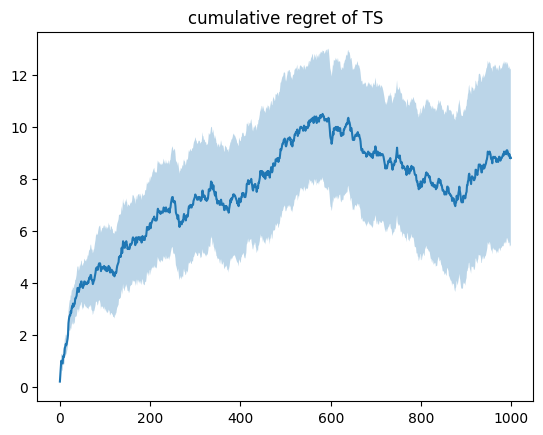

In [68]:
p = np.array([0.25, 0.5, 0.75])
T = 1000
n_trials = 20
# n_trials = 500

average_regret, regret_sd = evaluate_agent(p,T,lambda K,T: TSAgent(K), n_trials)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of TS')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()

### Visualization of the density functions

In [69]:
def plot_beta(alpha, beta, ax, samples=100, use_scipy=True):
    x = np.linspace(0,1,samples)
    y = (x**(alpha-1)) * ((1-x)**(beta-1))
    if use_scipy:
        y = beta_dist.pdf(x, alpha, beta) 
    else:
        beta_const_approx = np.sum(y*(1/samples)) # approximation
        y = y / beta_const_approx
    ax.plot(x,y)
    ax.fill_between(x,y,alpha=0.3)

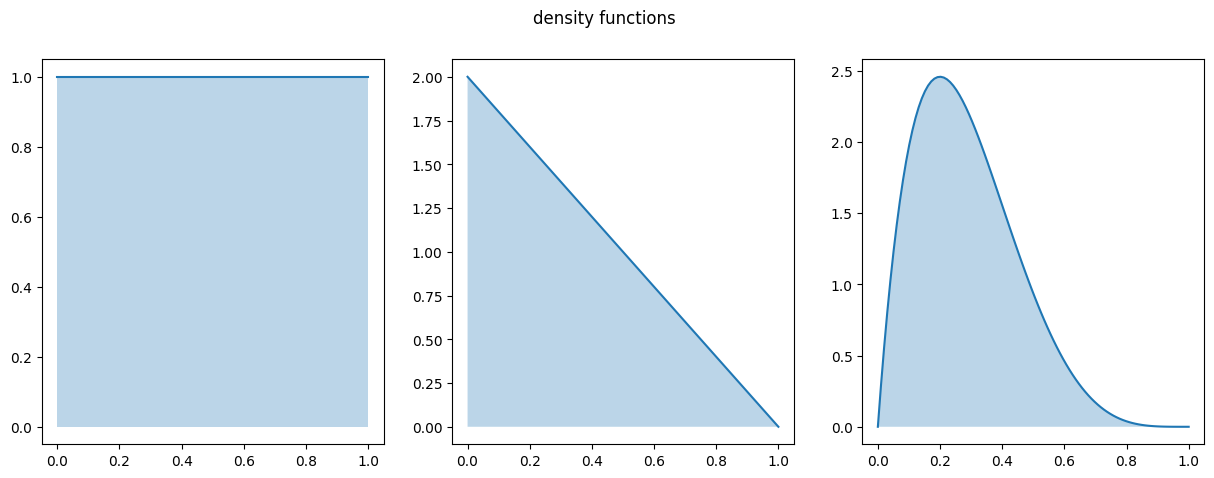

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
fig.suptitle('density functions')
plot_beta(1, 1, ax1)
plot_beta(1, 2, ax2)
plot_beta(2, 5, ax3)
plt.show()

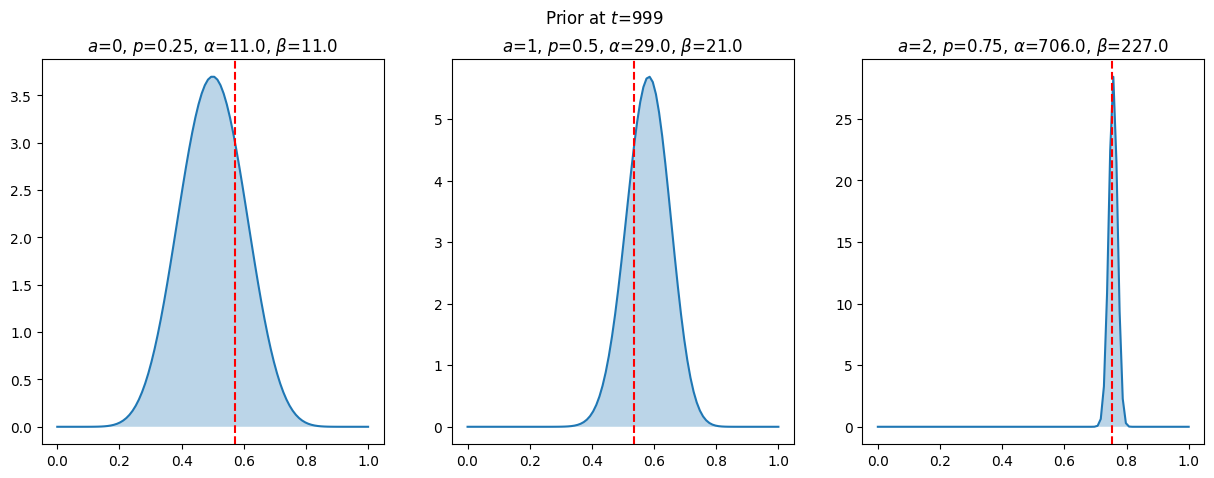

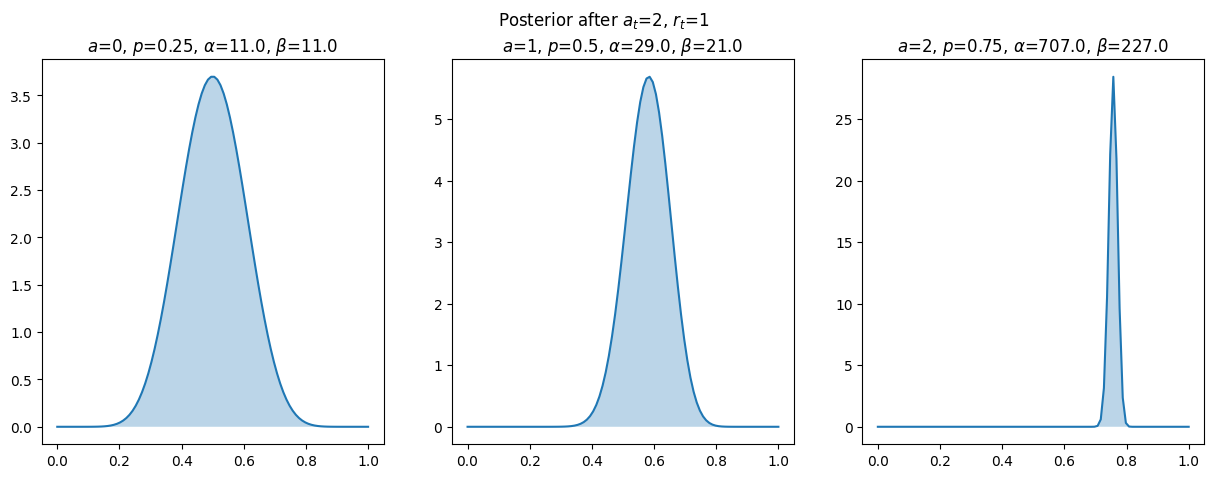

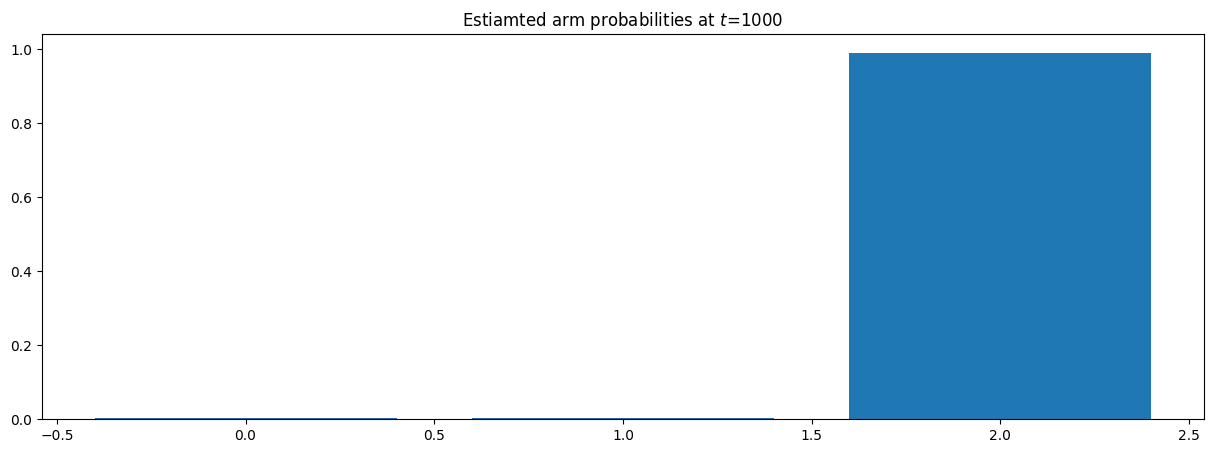

In [71]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000

np.random.seed(seed) #seed=17 is a bit unluky, arm 0 gives 10 success and failures
# np.random.seed(85) #better run and easier to follow
env = BernoulliEnvironment(p, T)
ts_agent = TSAgent(K)

next_plot_t = 10000
# next_plot_t = 0


for t in range(T):
    prior_alpha, prior_beta = ts_agent.alpha.copy(), ts_agent.beta.copy()
    
    a_t = ts_agent.pull_arm()
    r_t = env.round(a_t)
    ts_agent.update(r_t)

    posterior_alpha, posterior_beta = ts_agent.alpha, ts_agent.beta
    theta = ts_agent.theta[-1]

    if t == next_plot_t or t==T-1:
        state = np.random.get_state() # avoid altering the agent

        fig, axes = plt.subplots(1, K,figsize=(15,5))
        fig.suptitle('Prior at $t$={}'.format(t))
        for k in range(K):
            plot_beta(prior_alpha[k], prior_beta[k], axes[k])
            axes[k].axvline(theta[k], color='red', linestyle='dashed')
            axes[k].set_title('$a$={}, $p$={}, $\u03B1$={}, $\u03B2$={}'.format(k,p[k],prior_alpha[k],prior_beta[k]))
        plt.show()

        fig, axes = plt.subplots(1, K,figsize=(15,5))
        fig.suptitle('Posterior after $a_t$={}, $r_t$={}'.format(a_t,r_t))
        for k in range(K):
            plot_beta(posterior_alpha[k], posterior_beta[k], axes[k])
            axes[k].set_title('$a$={}, $p$={}, $\u03B1$={}, $\u03B2$={}'.format(k,p[k],posterior_alpha[k],posterior_beta[k]))
        plt.show()

        samples = np.stack([np.random.beta(posterior_alpha[k], posterior_beta[k], 10000) for k in range(K)])
        sampled_arms = np.argmax(samples, axis=0)
        n_pulls = [np.sum(sampled_arms==k)/len(sampled_arms) for k in range(K)]
        plt.figure(figsize=(15, 5))
        plt.title('Estiamted arm probabilities at $t$={}'.format(t+1))
        plt.bar([k for k in range(K)], n_pulls)
        plt.show()

        np.random.set_state(state)

    
    if t == next_plot_t:
        step = int(input())
        next_plot_t += step
        clear_output(wait=False)

## UCB1 vs Thompson Sampling

### Let's compare UCB1 and TS

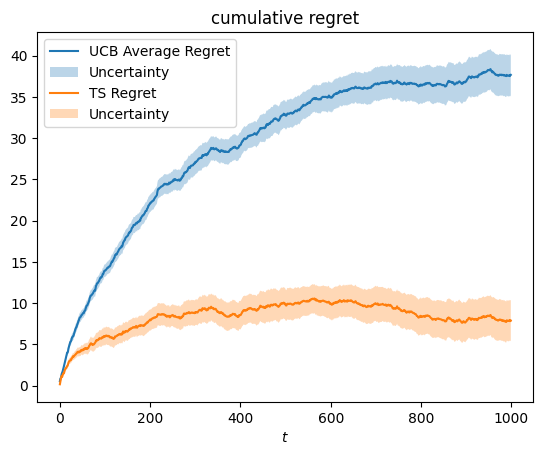

In [72]:
p = np.array([0.25, 0.5, 0.75])
K = len(p)
T = 1000

n_trials = 40

ucb_results, ts_results = compare_agents(p,T,
                                          lambda K,T : UCB1Agent(K, T), 
                                          lambda K,T : TSAgent(K),
                                          n_trials)
ucb_average_regret, ucb_regret_sd = ucb_results
ts_average_regret, ts_regret_sd = ts_results


plt.plot(np.arange(T), ucb_average_regret, label='UCB Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_regret-ucb_regret_sd/np.sqrt(n_trials),
                ucb_average_regret+ucb_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot(np.arange(T), ts_average_regret, label='TS Regret')
plt.fill_between(np.arange(T),
                ts_average_regret-ts_regret_sd/np.sqrt(n_trials),
                ts_average_regret+ts_regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.title('cumulative regret')
plt.xlabel('$t$')
plt.legend()
plt.show()


### Remark: theoretical guarantees of UCB1 and TS are nearly the same. Moreover, TS theoretical guarantees can be proven by showing that this strategy implicitly does optimism, thus the underlying principles of the two algorithms are the same.

## Injecting prior knowledge

### It is possible to change the intial prior to include some a priori knowledge on the distributions charaterizing the MAB

In [73]:
class TSAgentWithKnowledge(Agent):
    def __init__(self, K, prior=None):
        self.K = K
        self.a_t = None
        self.alpha, self.beta = (np.ones(K), np.ones(K)) if prior==None else prior
        # logging
        self.N_pulls = np.zeros(K)
        self.theta = []

    def pull_arm(self):
        theta = np.random.beta(self.alpha, self.beta)
        self.theta.append(theta)
        self.a_t = np.argmax(theta)
        return self.a_t
    
    def update(self, r_t):
        self.alpha[self.a_t] += r_t
        self.beta[self.a_t] += 1-r_t
        self.N_pulls[self.a_t] += 1

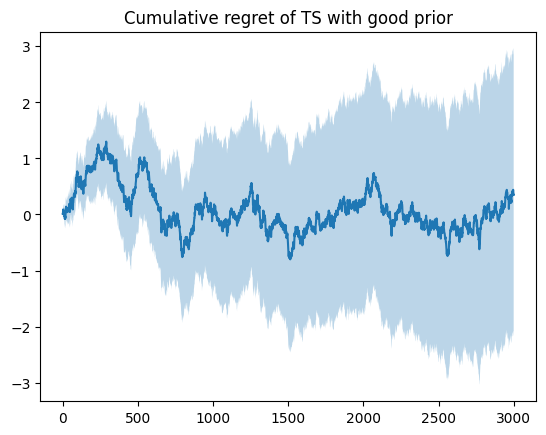

In [74]:
p = np.array([0.25, 0.5, 0.75])
T = 3000
n_trials = 100
# n_trials = 500

prior_alpha = np.ones(K)
prior_beta = np.ones(K)
prior_alpha[2] = 10
prior_beta[2] = 10
prior = (prior_alpha, prior_beta)

average_regret, regret_sd = evaluate_agent(p,T,
                                           lambda K,T: TSAgentWithKnowledge(K,prior),
                                           n_trials)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative regret of TS with good prior'.format(prior_alpha, prior_beta))
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()

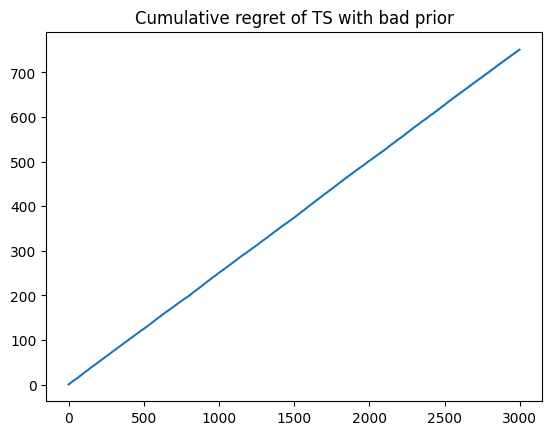

In [75]:
p = np.array([0.25, 0.5, 0.75])
T = 3000
n_trials = 100
# n_trials = 500

prior_alpha = np.ones(K)
prior_beta = np.ones(K)
prior_alpha[2] = 1
prior_beta[2] = 30
prior = (prior_alpha, prior_beta)

average_regret, regret_sd = evaluate_agent(p,T,
                                           lambda K,T: TSAgentWithKnowledge(K,prior),
                                           n_trials)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative regret of TS with bad prior'.format(prior_alpha, prior_beta))
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.show()

In [76]:
print('Expected pseudo regret when playing arm 1:',0.25*3000)

Expected pseudo regret when playing arm 1: 750.0


### Remark: TS can be used in any stochastic environment, however to move from Bernoulli distributed rewards to more general ones the algorithm needs some non-trivial adjustments. A good reference on coding TS for Gaussian rewards can be found here: https://gertjanvandenburg.com/blog/thompson_sampling/.

In [77]:
### Exercise: try to compare UCB1 and TS in a GaussianEnvironment